In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # use this for hi-dpi displays
%matplotlib inline

In [28]:
sns.set_style('whitegrid')  # set the plotting style

# Dataset description

> This experimental dataset has been acquired by **Yazan Alhadid** (yalhadid@ucla.edu).
> For more information on the science behind this kind of measurement see:
> - A Novel Initiation Pathway in Escherichia Coli Transcription, (2016), Lerner/Chung et al. 
> doi:[10.1101/042432](http://dx.doi.org/10.1101/042432) 

The dataset below contains two experimental kinetic curves representing DNA transcription by RNA polymerase
starting from two different initial states ITC2 and ITC7 (meaning that the RNAP has transcribed
2 or 7 nucleotides respectively). It is interesting to note that
the ITC7 kinetics is slower than the ITC2.

Each number in the table is the result of a smFRET measurements and represents 
a transcription efficiency measured after a certain amount of time.
Note that, for some time points the measurement has been performed only in
one configuration (either ITC2 or ITC7) so there are missing data points (NaN, not-a-number).

When fitting this dataset we need to make sure we correctly handle the NaN.


## Data format

The data has been saved in CSV (comma separated values) in Excel. 
We will load this data in a pandas DataFrame, a special python object
to hold tabular data.

### Difference between DataFrame and array

A numpy array is a contained for uniform type of data (for example integers, floats, etc.).
A numpy array can be 1-D (a vector), 2-D or N-D.
Conversely, a pandas DataFrame is a table (similar to a 2-D array)
in which each column can be of different type. 

Taking a 2-D array, you can access the columns (and rows) with a 
with a numerical index (0, 1, ...). So you need to know the meaning of
each row/column.

Conversely, in pandas DataFrame each column has a name, and you can select
a column by name. The first column of a DataFrame is a special column called the Index.
The index is used to select rows in the table. In our example the index is the time axis
that is common to the two columns representing the two set of measurements.

In [29]:
datafile = 'ITC2 ITC7 exit kinetics.csv'

In [30]:
d = pd.read_csv(datafile, index_col=0)
d

,ITC2,ITC7
Time(s),,
60,13.0,NaN
300,41.0,32.0
420,43.0,NaN
600,75.0,28.0
900,81.0,37.0
1200,89.0,62.0
1500,91.0,NaN
1800,NaN,82.0
2700,NaN,91.0


## Making plots from DataFrames

### Method1: use DataFrame.plot

A nice feature of DataFrames is that they can be quickly plotted:

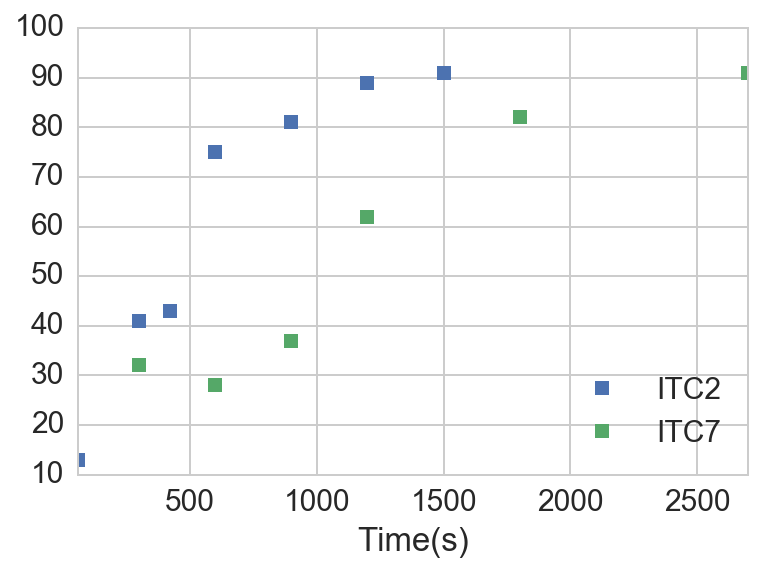

In [31]:
d.plot(marker='s', lw=0);

Note that the data of the two columns are plotted against the time axis (the index)
and the two columns are automatically labeled in the legend. Also the x-axis has
been labeled with the name associated with the index column.


> **Note for advanced users**
>
>In the command above, we used `df.plot`, meaning that the function `plot` comes from
>the DataFrame itself. This kind of functions contained in an object (and doing some
>operation on the object) are called methods. In other words, DataFrame has a plot method
>so it knows how to plot itself.

### Method2: use matplotlib's plot

For more control on the esthetics of the plot we can use matplotlib
function (`plt.plot`):

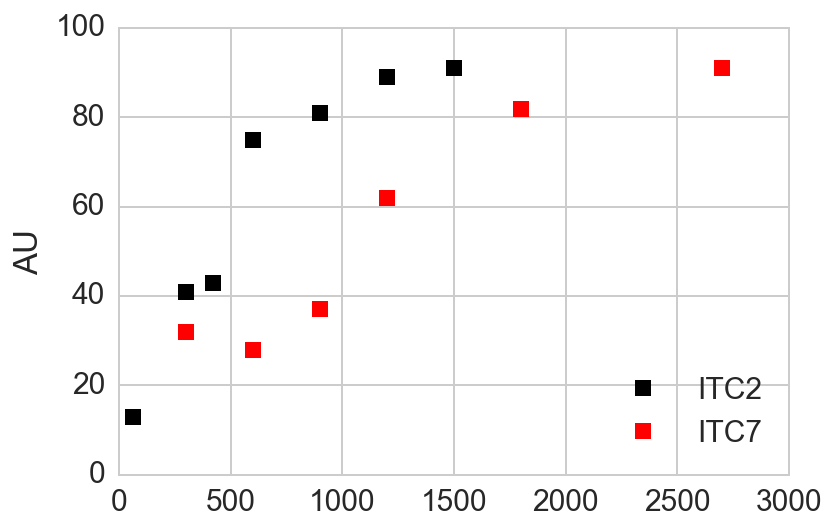

In [32]:
plt.plot('ITC2', data=d, lw=0, marker='s', ms=8, color='black')
plt.plot('ITC7', data=d, lw=0, marker='s', ms=8, color='red')
plt.ylim(0)
plt.xlim(0)
plt.ylabel('AU')
plt.legend(loc='best');

**Note**
    
- Instead of passing x, y arrays, here we pass the DataFrame (`data=df`)
- The first argument is the name of the y axis (e.g. 'ITC2')
- The x-axis is automatically taken from the dataframe index
- The labels for the legend are taken from the column names.
- Other arguments: `lw`: line width, `marker`: style of points ('s' = square, 'o' = circle), `ms`: marker size.

# Fitting the data

To fit the data we use the `lmfit` library.

In [33]:
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.5-28-g594092a


## Defining the model

We want to fit the data with an exponential curve that start at 0 for $t=0$ and goes
asymptotically to a value > 0 for $t=\infty$.

First we define a python function representing the mathematical function:

$$y = A\;\left(1 - e^{-\frac{x}{\tau}}\right)$$

In [34]:
def increasing_exp(x, tau=1, amplitude=1):
    return (1 - np.exp(-x/tau))*amplitude

Then, using the previous function, we create the model for fitting:

In [35]:
model = lmfit.Model(increasing_exp)

We "tweak" the model parameter setting initial values and bounds (this step is optional):

In [36]:
model.set_param_hint('amplitude', min=0)
model.set_param_hint('tau', value=100, min=0)

As a check, we print the resulting parameters:

In [37]:
params = model.make_params()

params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr
amplitude         1        0      inf     None     True     None
tau             100        0      inf     None     True     None


Finally we fit the model to the ITC2 data and print the fit results:

In [38]:
res2 = model.fit(d.ITC2, x=d.index, method='nelder', fit_kws=dict(nan_policy='omit'))

Name          Value      Min      Max   Stderr     Vary     Expr
amplitude     100.2        0      inf     None     True     None
tau           560.5        0      inf     None     True     None


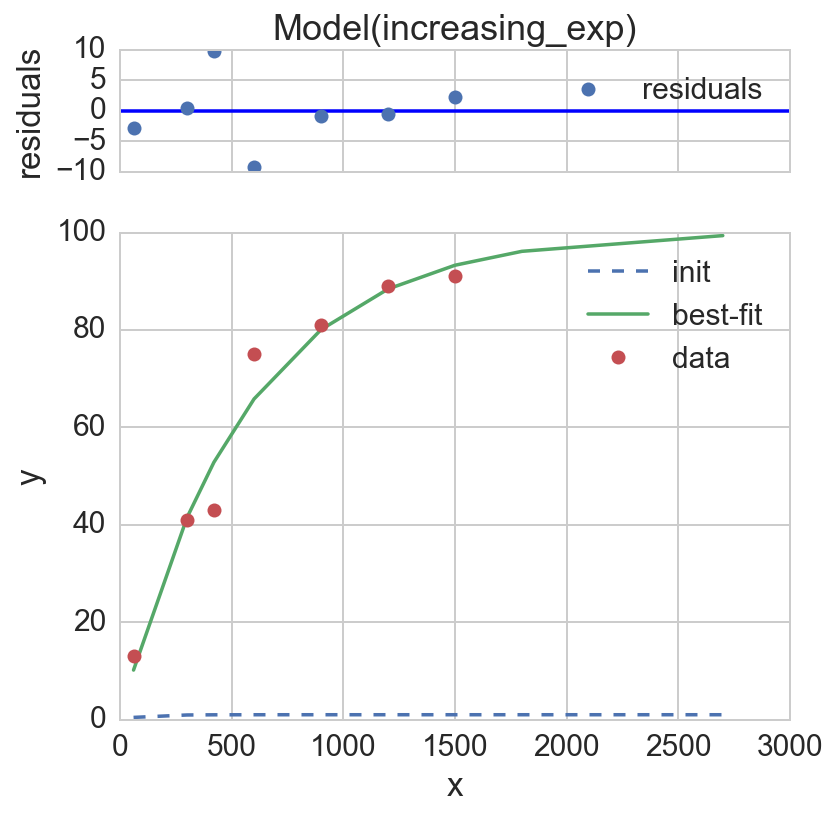

In [39]:
res2.params.pretty_print()
fig = res2.plot()

We fit the same model to the ITC7 data:

In [40]:
res7 = model.fit(d.ITC7, x=d.index, method='nelder', fit_kws=dict(nan_policy='omit'))

Name          Value      Min      Max   Stderr     Vary     Expr
amplitude     120.6        0      inf     None     True     None
tau            1812        0      inf     None     True     None


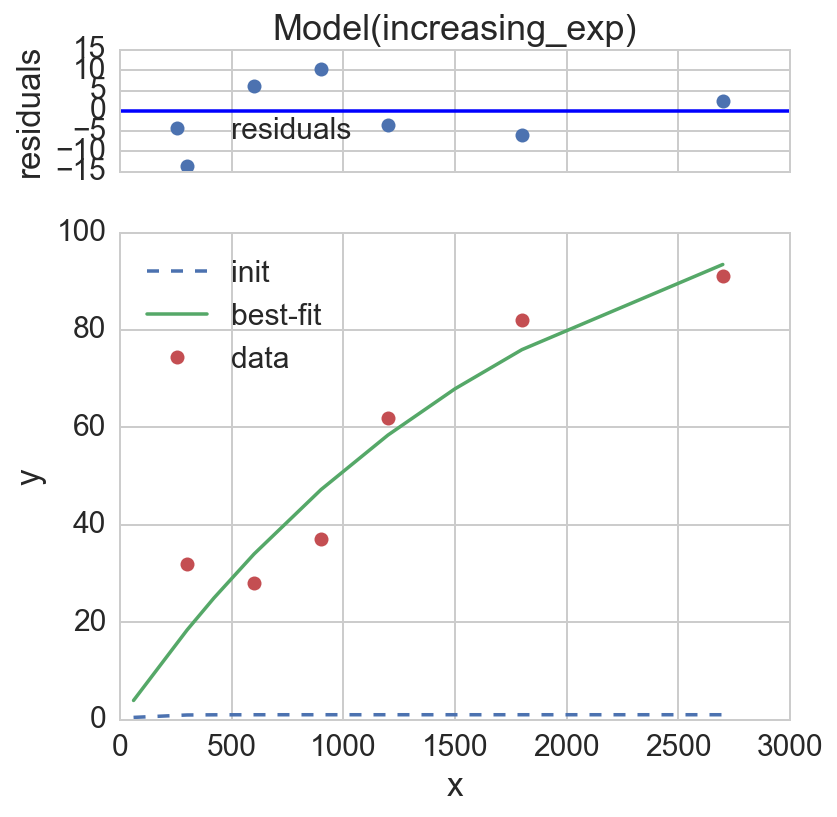

In [41]:
res7.params.pretty_print()
res7.plot();

## Fit comparison

As a last step we create a single plot which shows the two datasets and
the fitted curves.

In [42]:
t = np.arange(0, 3000)

In [43]:
res2.params.valuesdict()  # get a dictionary of parameters

OrderedDict([('amplitude', 100.19607850202087), ('tau', 560.48295649439569)])

In [44]:
y2 = increasing_exp(t, **res2.params.valuesdict())

In [45]:
y7 = increasing_exp(t, **res7.params.valuesdict())

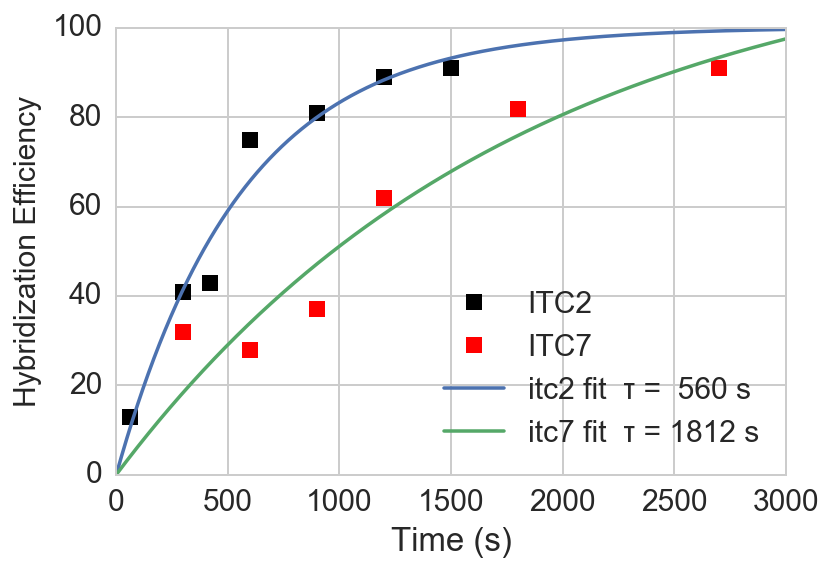

In [46]:
plt.plot('ITC2', data=d, lw=0, marker='s', ms=8, color='black')
plt.plot('ITC7', data=d, lw=0, marker='s', ms=8, color='red')
plt.ylim(0)
plt.xlim(0)
plt.ylabel('Hybridization Efficiency', fontsize =15)
plt.xlabel('Time (s)')
plt.plot(t, y2, label = 'itc2 fit  τ = %4d s' % res2.params['tau'].value)
plt.plot(t, y7, label = 'itc7 fit  τ = %4d s' % res7.params['tau'].value)
plt.legend(loc='best', fontsize = 15);

Setting the legend label was a little tricky. First we
got the fitted value for the parameter tau from the result object:

In [47]:
res2.params['tau'].value

560.48295649439569

Then we created the label (a string) which contains a integer number (%d):

In [48]:
'itc2 fit  τ=%d' % res2.params['tau'].value

'itc2 fit  τ=560'

This expression was passed as `label` in the previous plot.